# mnist-explanation

In this notebook, I try to implement explanation methods as described by G. Montavon et al. in their paper `Methods for Interpreting and Understanding Deep Neural Networks` [1]

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import utils ## Courtesy of http://www.heatmapping.org/tutorial
from tqdm.notebook import tqdm, trange
import os
import copy

In [2]:
mean, std = (0.1307, 0.3081)
transforms = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((mean,), (std,))
                             ])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [4]:
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Image Dimension: torch.Size([28, 28])


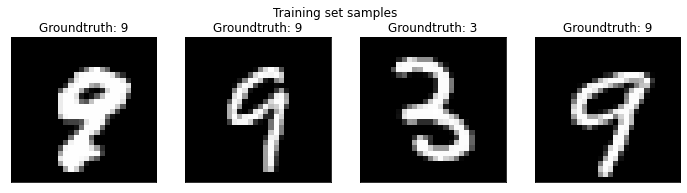

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(1,4)
fig.suptitle('Training set samples')
fig.set_size_inches(12,3)
for i in range(images.shape[0]):
    ax[i].imshow(images[i][0], cmap='gray')
    ax[i].set_title('Groundtruth: {}'.format(labels[i].item()))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
print('Image Dimension: {}'.format(images[0][0].shape))

## Neural Network Implementation

In their original paper, the researchers give advises on the kind of Deep Neural Network (DNN) to be used in order to maximise their explainability. We will follow the following advices:
 - Use as few fully-connected layers as needed to be accurate, and train these layers with dropout
 - Use sum-pooling layers abundantly, and prefer them to other types of pooling layers
 - In the linear layers (convolution and fully-connected), constrain biases to be zero or negative

As such, I will be using a very simple CNN: 2 convolutional layers with associated average-pooling layers followed by 3 fully-connected layers, using the Leaky RELU activation function.

In [6]:
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias.clamp(max=0), self.stride,
                        self.padding, self.dilation, self.groups)
    
class ConstrainedLinear(nn.Linear):
    def forward(self, input):
        return F.linear(input, self.weight, self.bias.clamp(max=0))

In [7]:
dnn = nn.Sequential(
    ConstrainedConv2d(1, 6, 3),
    nn.LeakyReLU(),
    nn.AvgPool2d(2),
    ConstrainedConv2d(6, 16, 3),
    nn.LeakyReLU(),
    nn.AvgPool2d(2),
    nn.Flatten(),
    nn.Dropout(0.25),
    ConstrainedLinear(16 * 5 * 5, 120),
    nn.LeakyReLU(),
    nn.Dropout(0.25),
    ConstrainedLinear(120, 84),
    nn.LeakyReLU(),
    nn.Dropout(0.25),
    ConstrainedLinear(84, 10),
    nn.BatchNorm1d(10, affine=False),
    nn.Sigmoid()
)

print(dnn)

Sequential(
  (0): ConstrainedConv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): ConstrainedConv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.25, inplace=False)
  (8): ConstrainedLinear(in_features=400, out_features=120, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Dropout(p=0.25, inplace=False)
  (11): ConstrainedLinear(in_features=120, out_features=84, bias=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): Dropout(p=0.25, inplace=False)
  (14): ConstrainedLinear(in_features=84, out_features=10, bias=True)
  (15): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (16): Sigmoid()
)


I use the Adam optimiser (using PyTorch default values) together with the Categorical Cross-Entropy loss function, over 10 epochs.

In [8]:
opt = torch.optim.Adam(dnn.parameters())
cce = nn.CrossEntropyLoss()
epochs = 10
model_path = './model.pt'
force_train = False

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/15000 [00:00<?, ?it/s]

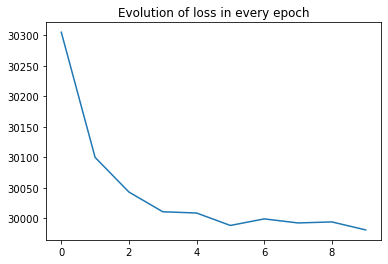

In [9]:
# Training
# Is skipped if saved model exists and training is not forced through dedicated constant
if os.path.isfile(model_path) and not force_train:
    dnn = torch.load(model_path)
else:
    losses = np.zeros(epochs)
    for epoch in trange(epochs, desc='Epochs'):
        epoch_loss = 0.0
        for data in tqdm(trainloader, desc='Epoch {}'.format(epoch)):
            inputs, labels = data
            opt.zero_grad()
            outputs = dnn(inputs)
            loss = cce(outputs, labels)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        losses[epoch] = epoch_loss
        
    torch.save(dnn, model_path)
        
    plt.plot(losses)
    plt.title('Evolution of loss in every epoch')
    plt.show()

In [10]:
dnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader, desc='Testing'):
        images, labels = data
        outputs = dnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {:2}%'.format(total*4, 100.*correct/total))

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy of the network on the 40000 test images: 98.79%


With 98.72% accuracy over the test set, the result is judged satisfactory enough to be used in the explanation framework.

## Explanation

Explanation is defined by the researchers as follows: `An explanation is the collection of features of the interpretable domain, that have contributed for a given example to produce a decision (e.g. classification or regression)`.

In this notebook, I will try to reproduce some of their methods on the DNN defined above.

### Setting up explanation framework

We will be testing our framework on all different digits: as such, we prepare a collection containing an example image for each digit, from the test set.

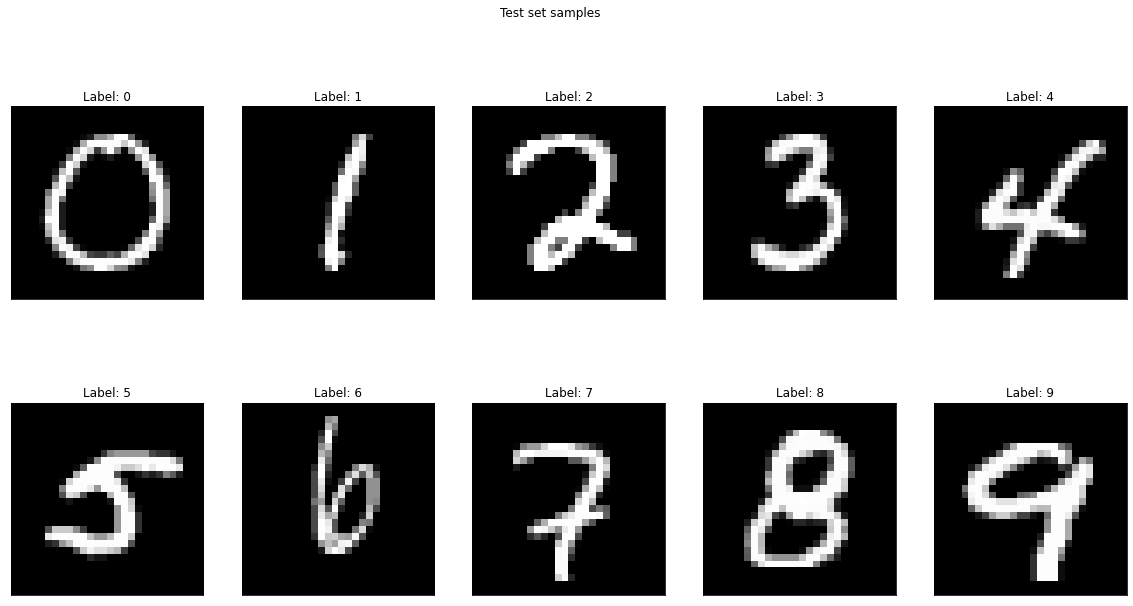

In [11]:
testloader = iter(torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2))
samples = torch.rand((10,1,28,28,), requires_grad=True)
slabels = torch.ones(10, dtype=torch.int64)
found_sample = [False] * 10

while False in found_sample:
    data, label = testloader.next()
    if found_sample[label.item()] == False:
        with torch.no_grad():
            samples[label.item()][0] = data
            slabels[label.item()] = label.item()
            found_sample[label.item()] = True
        
fig, ax = plt.subplots(2,5)
fig.suptitle('Test set samples')
fig.set_size_inches(20,10)
for i in range(samples.shape[0]):
    ax[i//5][i%5].imshow(samples.detach().numpy()[i][0], cmap='gray')
    ax[i//5][i%5].set_title('Label: {}'.format(i))
    ax[i//5][i%5].set_xticks([])
    ax[i//5][i%5].set_yticks([])
    
plt.show()

### Sensitivity analysis

In the scope of sensibility analysis, we study the gradient of the output with regard to the input. Here are the examples with regard to the selected samples. They are very similar to the one proposed by the research paper, I thus consider the replication to be successful.

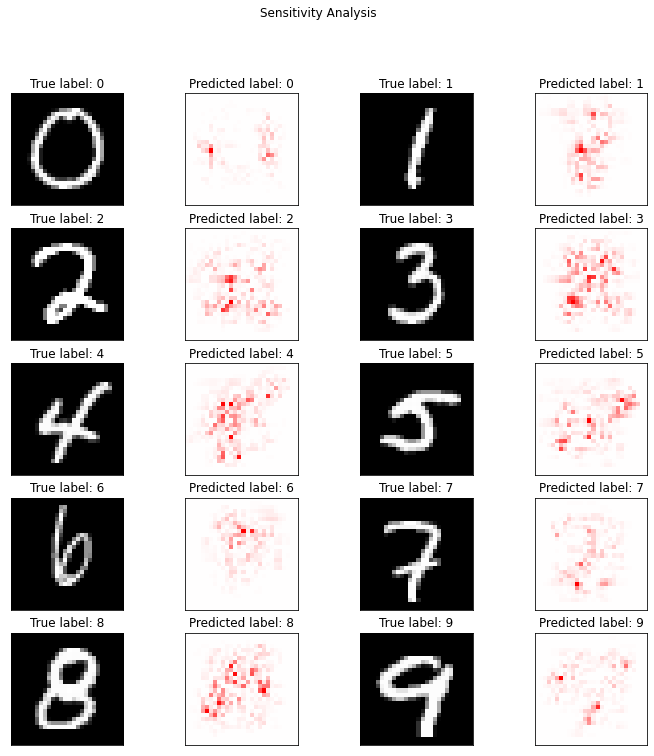

In [12]:
def plot_analysis_results(samples, relevance, outputs, title):
    fig, ax = plt.subplots(5,4)
    fig.suptitle(title)
    fig.set_size_inches(12,12)
    for i in range(samples.shape[0]):
        sample = i*2
        ssanal = sample+1
        
        # Original picture
        
        ax[sample//4][sample%4].imshow(samples.detach()[i][0], cmap='gray')
        ax[sample//4][sample%4].set_title('True label: {}'.format(i))
        ax[sample//4][sample%4].set_xticks([])
        ax[sample//4][sample%4].set_yticks([])
    
        #Relevance scores
        
        # If we want to represent negative values in blue and positive ones in red, we need
        # to normalise data so that the cmap is centred around 0
        mini = relevance[i].min().item()
        norm = None
        if mini < 0:  
            norm = mpl.colors.TwoSlopeNorm(vmin=mini, vcenter=0, vmax=relevance[i].max().item())
        else:
            maxi = relevance[i].max().item()
            norm = mpl.colors.TwoSlopeNorm(vmin=-maxi, vcenter=0, vmax=maxi)
            
        ax[ssanal//4][ssanal%4].imshow(relevance.detach()[i][0], cmap='bwr', norm=norm)
        ax[ssanal//4][ssanal%4].set_title('Predicted label: {}'.format(outputs[i].argmax().item()))
        ax[ssanal//4][ssanal%4].set_xticks([])
        ax[ssanal//4][ssanal%4].set_yticks([])

opt.zero_grad()
outputs = dnn(samples)
loss = cce(outputs, slabels)
loss.backward(retain_graph=True)

plot_analysis_results(samples, samples.grad ** 2, outputs, 'Sensitivity Analysis')

### Simple Taylor Decomposition

The simple Taylor decomposition uses the Taylor series of the gradient to derive a relevance score. In contrary to sensitivity analysis, this score can be either positive or negative and takes into account not only the gradient, but also the input value.

The results of this replication qualitatively match the paper's illustration.

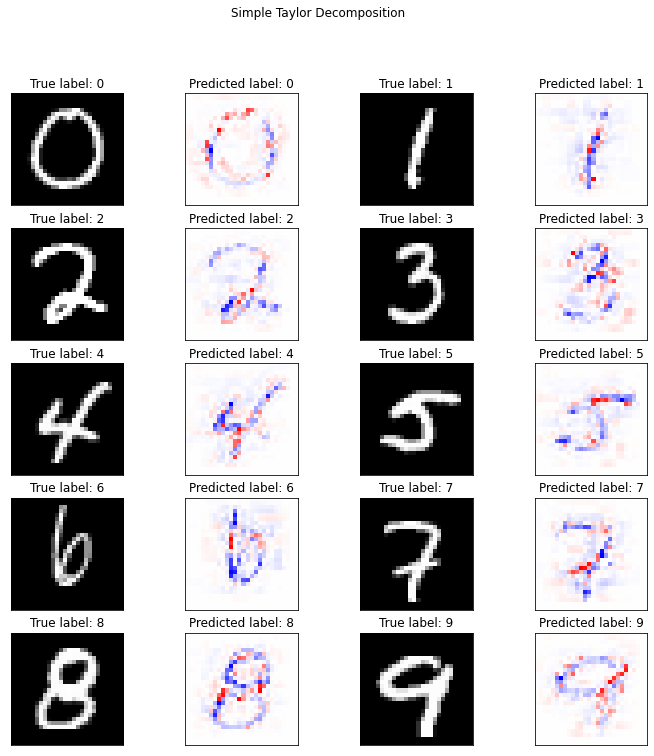

In [13]:
opt.zero_grad()
outputs = dnn(samples)
loss = cce(outputs, slabels)
loss.backward(retain_graph=True)

plot_analysis_results(samples, samples.grad * samples, outputs, 'Simple Taylor Decomposition')

### Layer-wise relevance propagation (LRP)

Layer-wise relevance propagation is a conserving backward propagation technique, designed precisely for explanation of DNNs. It is described in more details in another paper by the same author [2]. My implementation borrows a big part of the code proposed by the author as an example on http://heatmapping.org/tutorial

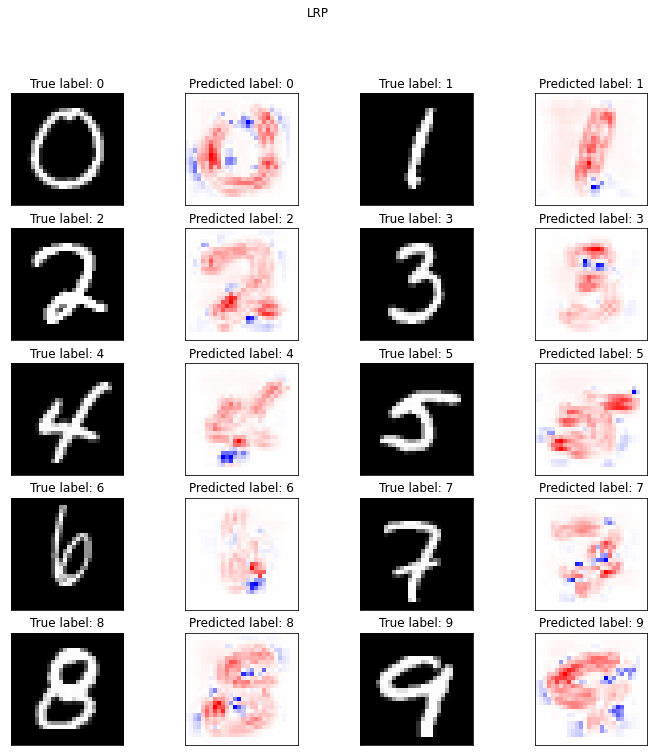

In [14]:
def lrp(model, X, y):
    """Returns the layer-wise relevance propagation for given input and model
    
    Args:
        model (nn.Module): Model
        X (torch.Tensor): Input
        y (torch.Tensor): Target classes
    
    Returns:
        torch.tensor: The relevance map in the input's dimension
    """
    
    # Preparing inputs
    layers = list(model._modules.values())
    L = len(layers)

    # Forward pass
    A = [X]+[None]*L
    for l in range(L):
        A[l+1] = layers[l].forward(A[l])
    
    # Masking to preserve only true class
    mask = np.zeros((y.shape[0],10))
    for i in range(y.shape[0]):
        mask[i][int(y[i])] = 1.
    mask = torch.FloatTensor(mask)
    R = [None]*L + [(A[-1]*mask).data]

    # Backward pass
    for l in range(1,L)[::-1]:
        
        A[l] = (A[l].data).requires_grad_(True)

        if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

        if isinstance(layers[l],ConstrainedConv2d) \
            or isinstance(layers[l],torch.nn.AvgPool2d) \
            or isinstance(layers[l],ConstrainedLinear):

            if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9
        
            z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad                  # step 3
            R[l] = (A[l]*c).data                                   # step 4
        
        elif isinstance(layers[l], nn.Flatten):
            R[l] = R[l+1].reshape(10, 16, 5, 5)
        
        else:
            R[l] = R[l+1]
    
    # Special case of input layer 
    A[0] = (A[0].data).requires_grad_(True)

    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

    z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/z).data                                                      # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4
            
    return R[0]

plot_analysis_results(samples, lrp(dnn, samples, np.arange(10)), dnn(samples), 'LRP')

### De-noising LRP by using translations

The authors advise using what they call a "translation trick" to help de-noising heatmaps. The principle is simple: translating the base image, applying the LRP, doing the inverse translation and averaging results over all translations.

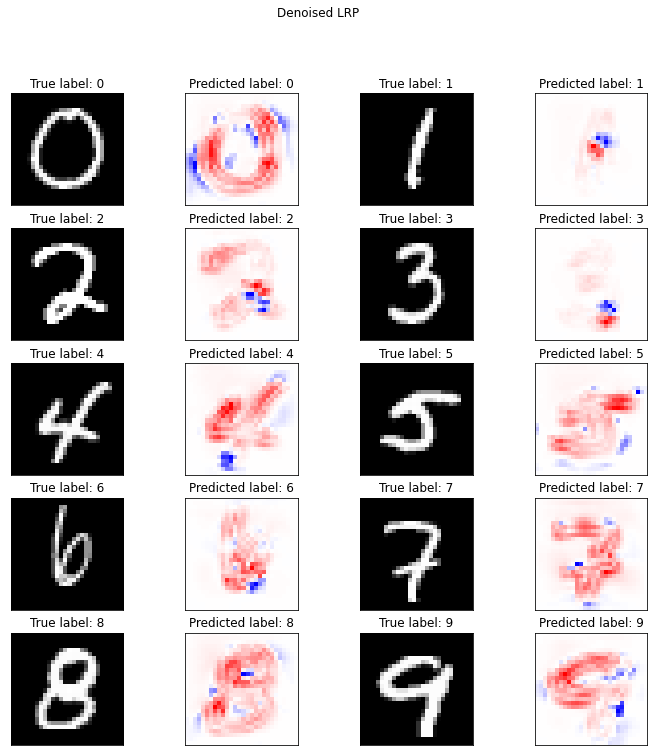

In [15]:
from torchvision.transforms.functional import affine

def denoised_lrp(model, X, y, pixels=0):
    translations = 1 + pixels*2
    heatmaps = torch.empty([translations**2] + list(X.shape))
    
    for i in range(translations):
        for j in range(translations):
            X_tr = affine(X, translate=[i-pixels,j-pixels], angle=0., scale=1., shear=[0.,0.])
            R = lrp(model, X_tr, y)
            heatmaps[i*translations+j] = affine(R, translate=[-i+pixels,-j+pixels], angle=0., scale=1., shear=[0.,0.])
            
    return torch.mean(heatmaps, axis=0)

plot_analysis_results(samples, denoised_lrp(dnn, samples, np.arange(10), pixels=2), dnn(samples), 'Denoised LRP')

## Interpretation

Within the interpretation framework, we aim at interpreting concepts learned by a DNN. In order to achieve this, we can use the Activation Maximisation technique: through gradient ascent, we try to produce the input that maximises the response of the model

  0%|          | 0/100000 [00:00<?, ?it/s]

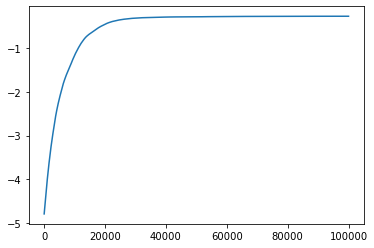

In [53]:
def activation_maximisation(model, target, N=100_000, lr=0.01, lambda_=0.005):
    X = torch.ones((1,1,28,28), requires_grad=True)
    losses = np.zeros(N)
    
    for i in trange(N):
        y = dnn(X)
        loss = torch.log(y[0][target]) - lambda_*(X.norm())**2
        losses[i] = loss.item()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            X = X + lr*X.grad
        X.requires_grad = True
    
    plt.plot(losses)
    
    return X

opt.zero_grad()
am = activation_maximisation(dnn, 0)

tensor([[0.9045, 0.3916, 0.3674, 0.3685, 0.3894, 0.3726, 0.3911, 0.3982, 0.3912,
         0.3760]], grad_fn=<SigmoidBackward>)
tensor([0.9726, 0.3899, 0.3670, 0.3688, 0.3890, 0.3702, 0.3901, 0.3970, 0.3894,
        0.3759], grad_fn=<SelectBackward>)


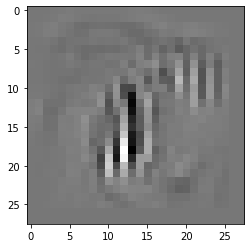

In [54]:
print(dnn(am))
print(dnn(samples)[0])
plt.imshow(am.detach()[0][0], cmap='gray')

## References

[1] Grégoire Montavon, Wojciech Samek, Klaus-Robert Müller, Methods for interpreting and understanding deep neural networks, Digital Signal Processing, Volume 73, 2018, Pages 1-15, ISSN 1051-2004, https://doi.org/10.1016/j.dsp.2017.10.011. (https://www.sciencedirect.com/science/article/pii/S1051200417302385)

[2] Montavon G., Binder A., Lapuschkin S., Samek W., Müller KR. (2019) Layer-Wise Relevance Propagation: An Overview. In: Samek W., Montavon G., Vedaldi A., Hansen L., Müller KR. (eds) Explainable AI: Interpreting, Explaining and Visualizing Deep Learning. Lecture Notes in Computer Science, vol 11700. Springer, Cham. https://doi.org/10.1007/978-3-030-28954-6_10